In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt

from embedding import load_emb_vectors, build_emb_weight
from loadData import create_dataset_obj
from model import create_emb_layer, two_stage_RNN, test_model
from preprocess import token2index_dataset 

RANDOM_STATE = 42

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Get pre-trained embeddings

In [2]:
# encode the pretrained embedding to text file
model = KeyedVectors.load_word2vec_format('/home/hb1500/Plated/vocab.bin', binary=True)
model.save_word2vec_format('pretrained_embd.txt', binary=False)

In [3]:
fname = '../../data/glove.6B.50d.txt'
words_emb_dict = load_emb_vectors(fname)

### Load Cleaned Data 

In [83]:
steps = ['step_one','step_two', 'step_three', 'step_four', 'step_five', 'step_six']
steps_aug = ['step_one_sp', 'step_two_sp', 'step_three_sp',
             'step_four_sp', 'step_five_sp', 'step_six_sp']
tags = ['tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
        'tag_cuisine_asian', 'tag_cuisine_mexican',
        'tag_cuisine_latin-american', 'tag_cuisine_french',
        'tag_cuisine_italian', 'tag_cuisine_african',
        'tag_cuisine_mediterranean', 'tag_cuisine_american',
        'tag_cuisine_middle-eastern']

In [84]:
data_with_aug = pd.read_csv('../data/recipe_data_with_aug.csv', index_col=0)

In [85]:
data_with_aug_tags = data_with_aug[steps+steps_aug+tags]

In [86]:
print(data_with_aug_tags.columns)

Index(['step_one', 'step_two', 'step_three', 'step_four', 'step_five',
       'step_six', 'step_one_sp', 'step_two_sp', 'step_three_sp',
       'step_four_sp', 'step_five_sp', 'step_six_sp', 'tag_cuisine_indian',
       'tag_cuisine_nordic', 'tag_cuisine_european', 'tag_cuisine_asian',
       'tag_cuisine_mexican', 'tag_cuisine_latin-american',
       'tag_cuisine_french', 'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern'],
      dtype='object')


### Tokenization

In [90]:
print('Processing original instruction data')
# tokenize each steps on original datasets
steps_token = []
for step in steps:
    steps_token.append(step+'_token')
    data_with_aug_tags[step+'_token'] = tokenize_dataset(data_with_aug_tags[step])
    print(step, 'has been tokenized.')

# tokenize each steps on augmented datasets
print('Processing augmented instruction data')
steps_aug_token = []
for step in steps_aug:
    steps_aug_token.append(step+'_token')
    data_with_aug_tags[step+'_token'] = tokenize_dataset(data_with_aug_tags[step])
    print(step, 'has been tokenized.')

Processing original instruction data
null
null
null
null


/home/tx443/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


step_one has been tokenized.
null
null
null
null
step_two has been tokenized.
null
null
null
null
step_three has been tokenized.
null
null
null
null
null
null
step_four has been tokenized.
null
null
null
null
null
null
null
null
step_five has been tokenized.
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
step_six has been tokenized.
Processing augmented instruction data
null
null
null
null


/home/tx443/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


step_one_sp has been tokenized.
null
null
null
null
step_two_sp has been tokenized.
null
null
null
null
step_three_sp has been tokenized.
null
null
null
null
null
null
step_four_sp has been tokenized.
null
null
null
null
null
null
null
null
step_five_sp has been tokenized.
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
step_six_sp has been tokenized.


In [92]:
data_with_aug_tags = data_with_aug_tags[steps_token+steps_aug_token+tags]

In [93]:
data_with_aug_tags.columns

Index(['step_one_token', 'step_two_token', 'step_three_token',
       'step_four_token', 'step_five_token', 'step_six_token',
       'step_one_sp_token', 'step_two_sp_token', 'step_three_sp_token',
       'step_four_sp_token', 'step_five_sp_token', 'step_six_sp_token',
       'tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
       'tag_cuisine_asian', 'tag_cuisine_mexican',
       'tag_cuisine_latin-american', 'tag_cuisine_french',
       'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern'],
      dtype='object')

# Split train and test sets

In [95]:
train, test_data = train_test_split(data_with_aug_tags, test_size=0.1, random_state=RANDOM_STATE)
test_data = test_data[steps_token+tags]
#train_data, val_data, train_tags, val_tags = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

In [106]:
aug2ori_colname = dict(zip(steps_aug_token+tags, steps_token+tags))

Cross validation for train and validation 

In [120]:
rnn_types = {
    'rnn': nn.RNN,
    'lstm': nn.LSTM,
    'gru': nn.GRU
}

params = dict(
    rnn1_type = 'gru',
    rnn2_type = 'gru',
    bi = True,
    hidden_dim1 = 30,
    hidden_dim2 = 30,
    num_classes = 1,
    
    num_epochs = 5,
    batch_size = 50,
    learning_rate = 0.01,
    add_data_aug = True,
    cuda_on = True
)

In [121]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
k = 1
predicted_tags = 'tag_cuisine_american' 
for train_index, val_index in kf.split(train):
    print('===================== This is the Kfold {} ====================='.format(k))
    k += 1
    val_data = train[steps_token+tags].iloc[val_index]
    train_data = train.iloc[train_index]
    
    if params['add_data_aug']:
        ##### add augmentation to training set by index #####
        train_org = train_data[steps_token+tags]
        train_aug = train_data[steps_aug_token+tags]
        train_aug.rename(index=str, columns=aug2ori_colname, inplace=True)
        # concatenate dfs
        train_data = pd.concat([train_org, train_aug], axis=0, ignore_index=False)
        ##### add augmentation to training set by index #####
    else:
        train_data = train_data[steps_token+tags]
    
    #print(len(train_data), len(train_data.dropna()))
    #look up
    train_targets = list(train_data[predicted_tags])
    val_targets = list(val_data[predicted_tags])
    test_targets = list(test_data[predicted_tags])
    
    train_X = train_data[steps_token]
    val_X = val_data[steps_token]
    test_X = test_data[steps_token]
    all_train_tokens = all_tokens_list(train_X)
    max_vocab_size = len(list(set(all_train_tokens)))
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    emb_weight = build_emb_weight(words_emb_dict, id2token)
    train_data_indices = token2index_dataset(train_X, token2id)
    val_data_indices = token2index_dataset(val_X, token2id)
    test_data_indices = token2index_dataset(test_X, token2id)

    # batchify datasets: 
    batch_size = params['batch_size']
    max_sent_len = np.array([94, 86, 87, 90, 98, 91])
    train_loader, val_loader, test_loader = create_dataset_obj(train_data_indices, val_data_indices,
                                                           test_data_indices, train_targets,
                                                           val_targets, test_targets,
                                                           batch_size, max_sent_len, 
                                                           collate_func)
    
    model_train(params, emb_weight, train_loader, val_loader, test_loader)

===================== This is the Kfold 1 =====================


/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/pandas-0.22.0-py3.6-linux-x86_64.egg/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


The number of train parameters 23071
1/5, Step:1/73, TrainLoss:0.673671, ValAUC:0.516710 ValAcc:0.754425
1/5, Step:11/73, TrainLoss:0.512991, ValAUC:0.536419 ValAcc:0.754425
1/5, Step:21/73, TrainLoss:0.590027, ValAUC:0.531796 ValAcc:0.754425
1/5, Step:31/73, TrainLoss:0.628712, ValAUC:0.569258 ValAcc:0.754425
1/5, Step:41/73, TrainLoss:0.592697, ValAUC:0.609839 ValAcc:0.754425
1/5, Step:51/73, TrainLoss:0.601926, ValAUC:0.651291 ValAcc:0.754425
1/5, Step:61/73, TrainLoss:0.494686, ValAUC:0.675121 ValAcc:0.754425
1/5, Step:71/73, TrainLoss:0.570093, ValAUC:0.723865 ValAcc:0.751047
Epoch: [1/5], trainAUC: 0.773962, trainAcc: 0.678326
Epoch: [1/5], ValAUC: 0.730364, ValAcc: 0.720652
2/5, Step:1/73, TrainLoss:0.532694, ValAUC:0.738950 ValAcc:0.719526
2/5, Step:11/73, TrainLoss:0.564985, ValAUC:0.784127 ValAcc:0.681250
2/5, Step:21/73, TrainLoss:0.413808, ValAUC:0.803413 ValAcc:0.734161
2/5, Step:31/73, TrainLoss:0.509308, ValAUC:0.808909 ValAcc:0.691381
2/5, Step:41/73, TrainLoss:0.425131

3/5, Step:21/73, TrainLoss:0.325463, ValAUC:0.839920 ValAcc:0.623247
3/5, Step:31/73, TrainLoss:0.550491, ValAUC:0.851758 ValAcc:0.596551
3/5, Step:41/73, TrainLoss:0.403525, ValAUC:0.853704 ValAcc:0.614348
3/5, Step:51/73, TrainLoss:0.192399, ValAUC:0.862447 ValAcc:0.622357
3/5, Step:61/73, TrainLoss:0.259391, ValAUC:0.865213 ValAcc:0.591211
3/5, Step:71/73, TrainLoss:0.457422, ValAUC:0.864627 ValAcc:0.609899
Epoch: [3/5], trainAUC: 0.947369, trainAcc: 0.653880
Epoch: [3/5], ValAUC: 0.861627, ValAcc: 0.639264
4/5, Step:1/73, TrainLoss:0.163323, ValAUC:0.859095 ValAcc:0.645493
4/5, Step:11/73, TrainLoss:0.207560, ValAUC:0.841139 ValAcc:0.634815
4/5, Step:21/73, TrainLoss:0.343780, ValAUC:0.840436 ValAcc:0.635705
4/5, Step:31/73, TrainLoss:0.366606, ValAUC:0.852532 ValAcc:0.608119
4/5, Step:41/73, TrainLoss:0.310932, ValAUC:0.853422 ValAcc:0.584982
4/5, Step:51/73, TrainLoss:0.174066, ValAUC:0.865635 ValAcc:0.572524
4/5, Step:61/73, TrainLoss:0.318437, ValAUC:0.865752 ValAcc:0.593881
4/

5/5, Step:51/73, TrainLoss:0.144132, ValAUC:0.831804 ValAcc:0.634599
5/5, Step:61/73, TrainLoss:0.094019, ValAUC:0.834004 ValAcc:0.659800
5/5, Step:71/73, TrainLoss:0.055982, ValAUC:0.827003 ValAcc:0.656364
Epoch: [5/5], trainAUC: 0.993137, trainAcc: 0.603041
Epoch: [5/5], ValAUC: 0.825098, ValAcc: 0.657509


In [119]:
def model_train(params, emb_weight, train_loader, val_loader, test_loader):
    rnn1_type = params['rnn1_type'] 
    rnn_1 = rnn_types[rnn1_type]
    rnn2_type = params['rnn2_type']
    rnn_2 = rnn_types[rnn2_type]
    bi = params['bi']
    hidden_dim1 = params['hidden_dim1']
    hidden_dim2 = params['hidden_dim2']
    num_classes = params['num_classes']
    batch_size = params['batch_size']
    cuda_on = params['cuda_on']

    weights_matrix = torch.from_numpy(emb_weight)
    model = two_stage_RNN(rnn_1, hidden_dim1, bi, rnn_2, hidden_dim2, batch_size, 
                          cuda_on, weights_matrix, num_classes)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print('The number of train parameters', sum([np.prod(p.size()) for p in model_parameters]))
    model = model.to(device)

    #parameter for training
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs'] # number epoch to train

    # Criterion and Optimizer
    criterion = nn.BCEWithLogitsLoss() #torch.nn.BCELoss(); torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss_list = []
    train_AUC_list = []
    val_AUC_list = []
    train_ACC_list = []
    val_ACC_list = []
    for epoch in range(num_epochs):
        for i, (steps_batch, lengths_batch, labels_batch) in enumerate(train_loader):
            for step_id in range(6):
                lengths_batch[step_id] = lengths_batch[step_id].to(device)
                steps_batch[step_id] = steps_batch[step_id].to(device)
            model.train()
            optimizer.zero_grad()
            outputs = model(steps_batch, lengths_batch)
            loss = criterion(outputs, labels_batch.view(-1,1).float().to(device)) 
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
            # validate every 10 iterations
            if i % 10 == 0:
                val_auc, val_acc = test_model(val_loader, model)
                print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValAUC:{:.6f} ValAcc:{:.6f}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), loss, val_auc, val_acc))
        val_auc, val_acc = test_model(val_loader, model)
        train_auc, train_acc = test_model(train_loader, model)
        train_AUC_list.append(train_auc)
        val_AUC_list.append(val_auc)
        train_ACC_list.append(train_acc)
        val_ACC_list.append(val_acc)
        print('Epoch: [{}/{}], trainAUC: {:.6f}, trainAcc: {:.6f}'.format(epoch+1, num_epochs, train_auc, train_acc))
        print('Epoch: [{}/{}], ValAUC: {:.6f}, ValAcc: {:.6f}'.format(epoch+1, num_epochs, val_auc, val_acc))
    return train_loss_list, train_AUC_list, val_AUC_list, train_ACC_list, val_ACC_list  

 All tokens from training set

In [25]:
# form all tokens list
all_train_tokens = all_tokens_list(train_data)

Let's decide which tag to predict for trail

In [23]:
data_cuisine_tags.iloc[:,1:].sum()/data_cuisine_tags.iloc[:,1:].shape[0]

tag_cuisine_indian            0.023525
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896
tag_cuisine_french            0.077352
tag_cuisine_italian           0.233254
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555
tag_cuisine_american          0.273525
tag_cuisine_middle-eastern    0.046252
dtype: float64

Choose tag: tag_cuisine_american, which 27.3525% are 1 

### Build vocabulary and indexing 

In [26]:
len(list(set(all_train_tokens)))

3157

In [27]:
token_counter = Counter(all_train_tokens)
# token_counter.most_common

In [31]:
emb_weight = build_emb_weight(words_emb_dict, id2token)

In [32]:
sum(np.sum(emb_weight,1)==0)/emb_weight.shape[0]

0.050015827793605569

Reconstruct data strcuture for datasets

tag_cuisine_indian            0.023525  85% auc
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217  98% auc
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896  90% auc
tag_cuisine_french            0.077352  72% auc
tag_cuisine_italian           0.233254  80% auc
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555  88% auc
tag_cuisine_american          0.273525  80% auc
tag_cuisine_middle-eastern    0.046252  87% auc

In [242]:
# test model
logits_all = []
labels_all = []
model.eval()
for steps_batch, lengths_batch, labels_batch in test_loader:
    for step_id in range(6):
        lengths_batch[step_id] = lengths_batch[step_id].to(device)
        steps_batch[step_id] = steps_batch[step_id].to(devi) 
    logits = model(steps_batch, lengths_batch)
    logits_all.extend(list(logits.cpu().detach().numpy()))
    labels_all.extend(list(labels_batch.numpy()))
logits_all = np.array(logits_all)
labels_all = np.array(labels_all)
auc = roc_auc_score(labels_all, logits_all)
predicts = (logits_all > 0.5).astype(int)
acc = np.mean(predicts==labels_all)

In [243]:
auc

0.82168113146898103

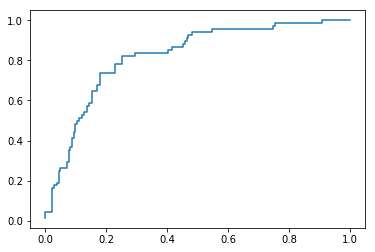

In [244]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_all, logits_all, pos_label=1)
plt.plot(fpr, tpr)

In [245]:
for p in model.parameters():
    if p.requires_grad:
        print(p.size())

torch.Size([90, 50])
torch.Size([90, 30])
torch.Size([90])
torch.Size([90])
torch.Size([90, 50])
torch.Size([90, 30])
torch.Size([90])
torch.Size([90])
torch.Size([90, 60])
torch.Size([90, 30])
torch.Size([90])
torch.Size([90])
torch.Size([1, 30])
torch.Size([1])
